## **PySpark**
<br>

### - **Dataset**: the data is the **labeled training set** (train.csv) **publicly available** on "Titanic - Machine Learning from Disaster" webpage and **you can download** it [here](https://www.kaggle.com/c/titanic/data?select=train.csv). <br>

### - **Objective**:  **create a ML model with PySpark** that **predicts which passengers survived the sinking of the Titanic**.<br>

- **Note**: we will **only use the original training set (which will be split into train and test sets) because it is labeled** and we do **want to evaluate the performance of our model**; the **original test set**, on the contrary, is **unlabeled**.<br>

### **Tasks**: 
- - - 
>- **EDA** 
>- **Feature Selection**
>- **Feature Engineering**
>- **Train-Test Split** (**within** the **training set**)
>- **Pipeline** 
>- **Classification: baseline model and hyperparameter tuning  with CrossValidator**  


#### **Import** most of the required **libraries**<br>

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import isnan, when, col,count,lit, regexp_extract, mean, avg, split
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### **Read** the **file**<br>

In [ ]:
# File location and type
file_location = "/FileStore/tables/train.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [ ]:
display(df.head(5))

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,null,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,null,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,null,S


#### **Descriptive statistics**

In [ ]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

####  **Using pandas** to have a **better visualization**<br>

In [ ]:

df.toPandas().describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



#### **Comments** regarding the **`Age` feature:**<br>
- The **age range varies from less than 0.5 years to 80 years**.  
- The **average age of the passengers is just below 30 years** and the **median age is slightly below the average**.
- One can **infer that there are 177 missing values**, as we'll **confirm when we check the missing values regarding all features**.
  <br><br>

#### **Check the schema**

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



#### **Check for missing values**<br>

In [ ]:

from pyspark.sql.functions import isnan, count, when, col
display(df.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df.columns]))

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,177,0,0,0,0,687,2


#### **How many survived?**

In [ ]:
display(df.groupBy("Survived").count())

Survived,count
1,342
0,549


#### **Comment:** 
- Regarding **our dataset more than 60% (≈ 61.6%) of the passengers didn't survive.**<br> (this **statistic can also be inferred from the descriptive statistics displayed above**).<br>


### How the **survival rate was correlated with some variables/features:**<br>
- - -

#### - **`Sex`:**

In [ ]:
display(df.groupBy("Sex","Survived").count())

Sex,Survived,count
male,0,468
female,1,233
female,0,81
male,1,109


#### **Comments:**
- Almost **65% of the travelers** of our dataset **were male** while the remaining **35% were female**. 
- What **stands out the most** is the **comparative percentage** of **women and men that survived**: almost **`75%` of the women survived** while **not even `20%` (≈18.9%) of the male passengers succeeded in surviving!**<br><br>

#### - **`Pclass`:**

In [ ]:
display(df.groupBy("Pclass","Survived").count())

Pclass,Survived,count
1,0,80
3,1,119
1,1,136
2,1,87
2,0,97
3,0,372


#### **Comments:**
- The **class3 had the highest number of travelers**, followed by class1 and the class with least passengers was the class2. The **number of travelers in class3** (the **least fortunate...**) **was more than the number of passengers in the class1 and class2 combined!**
- The **actual survival rate of a class1 traveler** was the **highest** one (**≈63%**). **Class2** and **class3 travelers** had an **actual survival rate of respectively 47.3% and 24,2%**. 
  <br><br>

#### - **`Age`:**

In [ ]:
df_pd = df.toPandas()

Out[16]: [Text(0.5, 0, 'Age Groups'), Text(0, 0.5, 'Number  of  Travelers')]

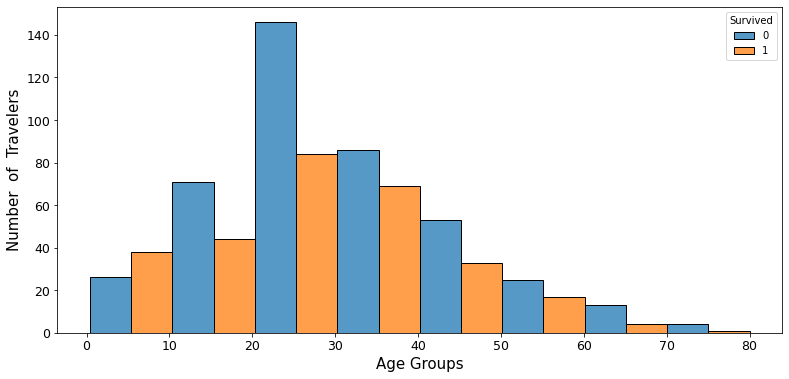

In [ ]:
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax = sns.histplot(data=df_pd, x="Age", hue="Survived",  multiple="dodge", bins=8)
ax.set(xlabel='Age Groups',
       ylabel='Number  of  Travelers')

#### **Comments:**
- The **only age group with a survival rate higher than 50% is the youngest one**.
- **Senior people** (older than 60 years old) **had a very low survival rate**.
- **Contrary to what could be expected** (in our perception...) **teenagers travelers and people in their twenties had a lower survival rate than people in their fourties and in their fifties**.
  <br><br>

In [ ]:
df.select('Age').distinct().count()

Out[17]: 89

#### - **`Embarked`:**<br>

In [ ]:
display(df.groupBy("Embarked","Survived").count())

Embarked,Survived,count
null,1,2
Q,1,30
S,0,427
S,1,217
C,1,93
Q,0,47
C,0,75


#### **Comments:**
- Embarked implies the **Port of Embarkation**: **C** = Cherbourg; **Q** = Queenstown; **S** = Southampton.
- The **majority of the travelers**, around **72% boarded from Southampton**. Approximatelly **19% boarded from Cherbourg** and the **remaining travelers boarded from Queenstown (almost 9%)**. 
- **Only the passengers who boarded from Cherbourg had an actual chance of survival greater than 50%**. Travellers who **boarded from Southampton** had **the actual least chance of survival (≈33%)**.<br><br>

#### - **`Fare`:**<br>

In [ ]:
display(df.groupBy("Fare","Survived").count())

Fare,Survived,count
28.5,0,1
56.4958,1,5
24.15,0,7
120.0,1,4
15.85,0,2
8.6625,0,12
79.2,0,2
36.75,0,1
8.4042,0,1
83.475,1,1


In [ ]:
df_pd.Fare.describe()

Out[21]: count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

#### **Splitting the fare feature into 4 categories according to the quartiles:**

In [ ]:
df_pd['Fare_Class'] = pd.cut(df_pd['Fare'], bins=[0,7.91,14.45,31,512.33], labels=['Low','Mid_Low-Mid','Mid-Mid_High','High'])

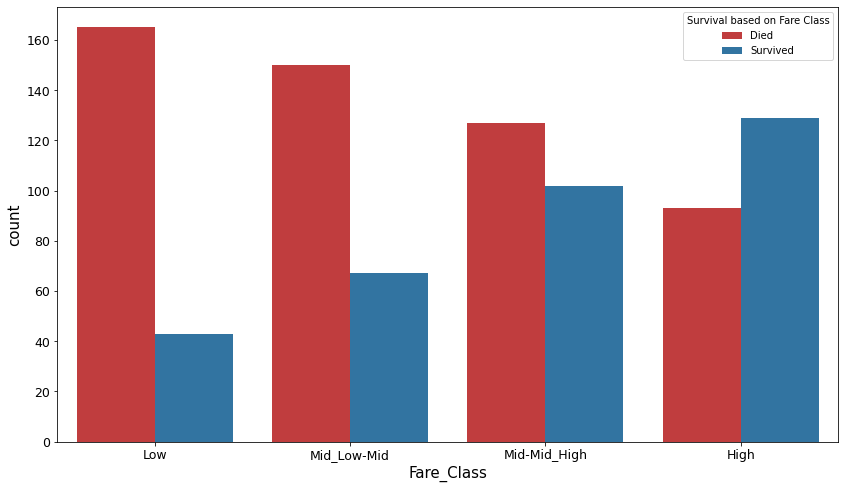

In [ ]:
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax_2 = sns.countplot(x = "Fare_Class", hue = "Survived", data = df_pd, palette=["C3", "C0"]).legend(labels = ["Died", "Survived"])
ax_2.set_title("Survival based on Fare Class")


#### **Comment:**<br>
- **Tendentially, the higher the fare the higher the survival rate**.<br><br>

#### - **`Ticket`:**<br>

In [ ]:
display(df.groupBy("Ticket","Survived").count())

Ticket,Survived,count
330958,1,1
350404,0,1
2693,0,1
349912,0,1
CA. 2343,0,7
244361,0,1
386525,1,1
A.5. 18509,0,1
218629,0,1
19950,0,2


In [ ]:

df.select('Ticket').distinct().count()

Out[25]: 681

#### **Comment:**<br>
- The tickets' number **does not translate into any valuable meaning to explain the chances of survival of a given passanger**. It was **something to be expected** after looking at the **descriptive statistics associated with this feature**.<br><br>

#### - **`Cabin`:**<br>

In [ ]:
df.groupBy("Cabin", "Survived").count().show(5)

+-----+--------+-----+
|Cabin|Survived|count|
+-----+--------+-----+
|  C78|       0|    1|
|   F2|       0|    1|
|   A7|       0|    1|
|  D45|       1|    1|
|  C47|       1|    1|
+-----+--------+-----+
only showing top 5 rows



In [ ]:
df.select('Cabin').distinct().count()

Out[27]: 148

#### **Comments:**
- What **we said about the feature tickets it is valid for the feature cabin: it does not translate into any valuable meaning to explain the chances of survival of a given passanger.**
- Besides, as we will see below, **the number of missing values regarding this variable it is very high, both in absolute (687) and relative terms (around 77%)**<br><br>

#### **Check for missing values**<br>

In [ ]:
display(df.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df.columns]))

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,177,0,0,0,0,687,2


- - - 

### **`Features Selection: 1st phase`:** <br><br>
 - **Removing unnecessary features before handling missing data regarding age and embarked features.**<br>

In [ ]:
df_pyspark=df.drop('Cabin','Ticket','PassengerId')

In [ ]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
only showing top 5 rows



#### **Comment:** 
- The **feature 'name' wasn't removed** because it will be **crucial for filling in the missing values regarding the feature age**.<br><br>
- - -

#### **`Imputing Missing Values`:**

#### **- Imputing missing values regarding `age` and `embarked` features**:<br>

#### - **`AGE`:**<br>
- To **replace the missing values, we could assign them the mean or median age of the dataset**. If we **used the distinct() and count() functions**, like we did above for other features, we would see that there were **many different ages**, **just by looking** at the **descriptive statistics** regarding the **age feature** one can tell that it **would not be appropriate to impute either the mean or median age to the missing values**.<br><br>
- **Assumptions**: **age is an important factor when it comes to survival rate**, for instance, the **youngest age group had higher chances of survival than senior people**. <br>The **available lifeboats, by regulation, are primarily used to save chlidren and women.**<br><br>
- We can use a **regex filter to extract the Title** and run this for every row of the dataframe and consequently **find the passangers who are women and children** (we'll **refine** this procedure latter on because **all unmarried females** across all ages had the 'Miss' title. However, among those females there were **young girls** and **adult females** with, most likely, **relevant different mean ages**), and **also adult males** with different **socio-professional categories**.<br><br>
  - **After extracting the title** we'll see that the **average age** can **vary significantly for the distinct titles**.<br><br>
    - We **won't just extract titles and assign the average age to the missing values**, we will be **more accurate** than that in **imputing missing ages** as **you will see later on**.<br><br>

In [ ]:
from pyspark.sql.functions import mean,col,split, regexp_extract, lit
df_pyspark = df_pyspark.withColumn("Title",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))

In [ ]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|   Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|  Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S| Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|  Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|   Mr|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
only showing top 5 rows



#### **Let's see the different titles in our dataset:**<br>

In [ ]:
df_pyspark.select("Title").distinct().show()

+--------+
|   Title|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



#### **Comments:**
- **There are titles that can be grouped into the same "categories"** like, for instance, **'Capt'** and **'Major' both are Officers**.
- Besides, there are titles that are either **misspelled** or that **although different and correctly spelled  mean the very same thing** like, for instance, **'Mlle' means 'Miss', 'Mme' means 'Mrs'** and **Ms" means "Miss"**.
- Regarding 'Dr' and 'Rev' we chose to replace them by 'Other'.<br><br>

#### Let's **replace the titles according to our rationale:**

In [ ]:
df_pyspark = df_pyspark.replace(['Capt','Col', 'Major', 'Jonkheer','Don','Sir','Dr','Rev','Countess','Mme','Mlle','Ms','Lady'],
               ['Officer','Officer','Officer','Royalty','Royalty', 'Royalty', 'Other','Other', 'Royalty', "Mrs", "Miss", 'Miss', "Royalty"])

In [ ]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|
|       0|     3|Palsson, Master. ...|  male| 2.0|    3|    1| 21.075|       S|Master|
|       1|     3|Johnson, Mrs. Osc...|femal

#### **Comments**: 
- **All unmarried females across all ages had the 'Miss' title**. However, among those females there were **young girls** and **adult females** with, most likely, **relevant different mean ages**.
- There is a **rationale** that we **may apply to  distinguish those two cases**: **if Parch > 0**, then most likely **they are female children traveling with at least one parent** (we will name the title as **'MissPar'**); **if Parch = 0**, then it's likely that they are adult females traveling alone (we will name the title as **'MissA'**). <br><br>

**Let us check how different are the mean ages for those two different cases:**<br>

In [ ]:
print("Average age of a Miss travelling without Parents 'MissA'", df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch==0)].agg(mean('Age').alias('mean')).collect())
print("Average age of a Miss travelling with Parents 'MissPar'", df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0)].agg(mean('Age').alias('mean')).collect())

Average age of a Miss travelling without Parents 'MissA' [Row(mean=27.68617021276596)]
Average age of a Miss travelling with Parents 'MissPar' [Row(mean=11.863636363636363)]


#### **Comment: the difference between the mean ages for the two different cases is noticeable!** <br>Being so, let's **add a column with the new titles for each of those cases replacing the 'Miss' title** by **'MissA'** and **'MissPar' accordingly**:<br>

In [ ]:
df_pyspark = df_pyspark.withColumn("NewTitle",
                        when((df_pyspark.Title=="Miss") & (df_pyspark.Parch==0), 'MissA')
                       .when((df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0), 'MissPar')
                       .otherwise(df_pyspark['Title']))
                      

In [ ]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|      Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|      Mr|
|       0|     3|Palsson, Master. ...|  


> - To be **more accurate** in **imputing missing ages** we will **compute the mean age of groups of `similar passengers`** considering some **`FEATURES COMBINED`**.<br><br>
> - For that, given the **huge difference regarding the actual survival rate among the three different classes** (Pclass1, Pclass2 and Pclass3), we'll **group the features `NewTitle` and `Pclass` to define groups of `similar passengers`** (in what concerns to those two features) and then **find** the **`average age`** of those **`similar passengers`**:<br><br>

In [ ]:
my_list = df_pyspark.groupby(['NewTitle', 'Pclass']).avg(('Age')).collect()

In [ ]:
spark.createDataFrame(my_list).show()

+--------+------+------------------+
|NewTitle|Pclass|          avg(Age)|
+--------+------+------------------+
|   MissA|     2|            30.375|
|     Mrs|     3|33.515151515151516|
|      Mr|     1| 41.58045977011494|
|   Other|     1|             43.75|
| MissPar|     3| 6.903846153846154|
| MissPar|     1|              21.0|
|   MissA|     1| 34.25806451612903|
|     Mrs|     1|              40.4|
|   Other|     2|              42.0|
|      Mr|     2| 32.76829268292683|
|  Master|     3| 5.350833333333334|
|   MissA|     3|21.697674418604652|
| Officer|     1|              56.6|
|      Mr|     3|28.724890829694324|
| Royalty|     1|              41.6|
|  Master|     2|2.2588888888888885|
|  Master|     1| 5.306666666666667|
| MissPar|     2|10.538461538461538|
|     Mrs|     2| 33.68292682926829|
+--------+------+------------------+



#### Let's **add a column** ('**AgeImputed**') and **replace the 'age' missing values assigning them the average age of the `similar passengers`**:<br>

In [ ]:
df_pyspark = df_pyspark.withColumn("AgeImputed",
                         when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 28.72)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 32.77)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.58)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 33.5)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 33.68)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 40.4)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 42)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 43.8)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 21.7)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 30.38)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 34.26)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 6.9)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 10.54)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 21)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 5.35)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 2.26)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 5.31)
                        .when((df_pyspark.NewTitle=="Officer|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 56.6)
                        .when((df_pyspark.NewTitle=="Royalty|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.6)
                        .otherwise(df_pyspark.Age))

#### - **`EMBARKED`**:<br>
- This feature has **only two missining values** and **almost 3/4 of the passengers boarded from "S"** (Southampton). **We'll impute "S"**.

In [ ]:
df_pyspark = df_pyspark.na.fill({"Embarked" : 'S'})

In [ ]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|AgeImputed|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|      22.0|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|      38.0|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|      26.0|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|      35.0|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|      35.0|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|      Mr|     28.72|
|       0|     1|McCarthy, Mr. Tim...

### **`Features Selection: 2nd phase`:** <br><br>
 - **Removing unnecessary features after the `FEATURE ENGINEERING`:**<br>

In [ ]:
df_pyspark=df_pyspark.drop('Name','Age','Title')

#### Let's **check** if **there are still any missing values**:<br>

In [ ]:
df_pyspark.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df_pyspark.columns]).show()

+--------+------+---+-----+-----+----+--------+--------+----------+
|Survived|Pclass|Sex|SibSp|Parch|Fare|Embarked|NewTitle|AgeImputed|
+--------+------+---+-----+-----+----+--------+--------+----------+
|       0|     0|  0|    0|    0|   0|       0|       0|         0|
+--------+------+---+-----+-----+----+--------+--------+----------+



#### **Check the schema after the changes we made**:

In [ ]:
df_pyspark.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- NewTitle: string (nullable = true)
 |-- AgeImputed: double (nullable = true)



### - Let's do some **more feature engineering**:<br>
- - -

#### **Create a function to convert categorical attributes into a binary vector with at most a single one-value per row that indicates the input category index** (using **OneHotEncoder**), the last category is not included by default), **but first convert non-numeric data to numeric data** (using **StringIndexer**):<br>

In [ ]:
stages=[]
cat=['Sex','Embarked','Pclass','NewTitle']

In [ ]:
for catCol in cat:
    indexer = StringIndexer(inputCol=catCol, outputCol=catCol+'Index',stringOrderType='frequencyDesc')
    encoder=OneHotEncoder(inputCols=[indexer.getOutputCol()],outputCols=[catCol+'catVec'])
    stages+=[indexer,encoder]
    
#indexer= StringIndexer(inputCol='Sex', outputCol='sex_Index',stringOrderType='frequencyDesc')
#df_pysparkcat = indexer.fit(df_pyspark).transform(df_pyspark)
#df_pysparkcat.show()


#df_pysparkcat = indexer.fit(df_pyspark).transform(df_pyspark)


In [ ]:
stages

Out[58]: [StringIndexer_a9156631b268,
 OneHotEncoder_60d49251a2f5,
 StringIndexer_a2f4c8f1cb1e,
 OneHotEncoder_c3c4d0168483,
 StringIndexer_7482265629ba,
 OneHotEncoder_3ff0ea5cfc62,
 StringIndexer_1623672dfa50,
 OneHotEncoder_516e6277d4ce]

#### Let's **combine the list of columns of our interest into a single vector column properly named 'features'** (using **VectorAssembler**):<br>

In [ ]:
numeric=['Fare','SibSp','Parch','AgeImputed']

In [ ]:
assembleInputs=[c+'catVec' for c in cat]+numeric
assembler=VectorAssembler(inputCols=assembleInputs,outputCol="features")
stages+=[assembler]

#### **Now** let´s do the **train-test split**:<br>

In [ ]:
train_data, test_data = df_pyspark.randomSplit([0.8,0.2],seed=42) 

#### Use a **pipeline to fit the train set**<br>

In [ ]:
pipeline=Pipeline().setStages(stages)
pipelineModel=pipeline.fit(train_data)

#### **Transform the train and test sets**<br>

In [ ]:
train_pipe=pipelineModel.transform(train_data)
test_pipe=pipelineModel.transform(test_data)

In [ ]:
train_pipe.head(1)

Out[65]: [Row(Survived=0, Pclass=1, Sex='female', SibSp=0, Parch=0, Fare=28.7125, Embarked='C', NewTitle='MissA', AgeImputed=50.0, SexIndex=1.0, SexcatVec=SparseVector(1, {}), EmbarkedIndex=1.0, EmbarkedcatVec=SparseVector(2, {1: 1.0}), PclassIndex=1.0, PclasscatVec=SparseVector(2, {1: 1.0}), NewTitleIndex=1.0, NewTitlecatVec=SparseVector(7, {1: 1.0}), features=SparseVector(16, {2: 1.0, 4: 1.0, 6: 1.0, 12: 28.7125, 15: 50.0}))]

## **Classification**<br>
- - -

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

#### - **Baseline model and evaluation:**

In [ ]:
rf = RandomForestClassifier(labelCol = 'Survived', predictionCol='prediction', seed=42)
rfmodel = rf.fit(train_pipe)

In [ ]:
pred_results_rf = rfmodel.transform(test_pipe)

In [ ]:
 # For the Training Set
summary=rfmodel.summary

summary.accuracy

Out[143]: 0.839142091152815

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Survived')

rfevaluator=evaluator.evaluate(pred_results_rf)
# equal to:
auroc = evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderROC"})

aupr= evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderPR"})
print(auroc,aupr)

0.8923692427790788 0.8592038032018966


### - **Hyperparameter tuning with CrossValidator and evaluation:**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 4, 5])
               .addGrid(rf.numTrees, [5, 10, 20, 100])
             .build())

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorRF=BinaryClassificationEvaluator(labelCol='Survived')

cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluatorRF,
                      numFolds = 5)

rfcv=cv.fit(train_pipe)

Deprecation warning: The PySpark MLlib + MLflow Tracking integration is deprecated. Soon, we will remove this feature and replace it with MLflow PySpark ML autologging and Databricks Autologging.
 To try the new MLflow PySpark ML autologging feature, which will be enabled by default in an upcoming release, call `mlflow.pyspark.ml.autolog()`.
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


In [ ]:
predictions=rfcv.bestModel.transform(test_pipe)

evaluatorRF.evaluate(predictions)

Out[149]: 0.9006635441061671

In [ ]:
# As, by default, the metric name of the BinaryClassificationEvaluator is areaUnderROC the first value will be equal to the cell above
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr= evaluatorRF.evaluate(predictions, {evaluatorRF.metricName: "areaUnderPR"})
print(auroc, aupr)


0.9006635441061671 0.894087760129106


#### - We **can get the accuracy and F1 score using MulticlassClassificationEvaluator** which **can be used for binary classification** as well. Let's use it for **accuracy:**

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
rf_accuracy = multi_evaluator.evaluate(predictions)
print("Accuracy of RandomForestClassifier is = ", (rf_accuracy))

Accuracy of RandomForestClassifier is =  0.8551724137931035


#### - **Model Evaluation with SciKit-Learn: Classification Report**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_true = predictions.select(['Survived']).collect()
y_pred = predictions.select(['prediction']).collect()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        84
           1       0.90      0.74      0.81        61

    accuracy                           0.86       145
   macro avg       0.87      0.84      0.85       145
weighted avg       0.86      0.86      0.85       145



- - - 

## **Conclusions**:<br>
-  **After completing the tasks** it's  fair to say that we managed to **meet the goal we set ourselves** given the **scores we achieved for the metrics commonly used for this dataset with Pyspark**.
- The **scores we achieved for the metrics were higher using hyperparameter tuning with CrossValidator than the ones we reached with the baseline model**, as expected.
- The model **can be improved** a little, namely in what concerns to **missing age values imputation** and by **using more classifiers**.